# Notebook to Preprocess MIMIC-III v1.4 Data Files

In this notebook we will preprocess the [MIMIC-III](https://physionet.org/content/mimiciii/1.4/) v1.4 data files as extracted by [MIMIC-Code](https://github.com/MIT-LCP/mimic-code). Here, we implement the preprocessing for the *handcrafted state-space approach* as used by [Roggeveen et al.](https://www.sciencedirect.com/science/article/pii/S0933365720312689), by aggregating measurements into bins of N-hours (originally 4 hours) starting from the 24 hour prior to sepsis onset to 48 hours after (72 hours in total).

The original notebook was written in R; I have reimplemented the preprocessing in Python and validated this reimplementation with the original notebook (minus small errors made in the original which I corrected, see `# Remark:` comments in the code cells below).

In [1]:
## Dependencies
# I/O
import os
import re
import pickle
import pandas as pd
import numpy as np

# Plotting
import random
import matplotlib.pyplot as plt

# Timing
from datetime import timedelta
from tqdm import tqdm

# Imputation
from fancyimpute import KNN

In [2]:
# Directory where mimic-iii is kept
DATA_DIR = '../data/mimic-iii/final/'

if not os.path.exists(DATA_DIR):
    raise Exception('Dataset directory %s does not exist!' % DATA_DIR)

# Directory where preprocessed data will be stored
OUTPUT_DIR = 'datasets/mimic-iii/roggeveen/'

# Create output_dir if not yet created
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
# Defines granularity of dataset generated
INTERVAL_TIME = '4h'

### Convenience functions
For simplicity, we define a number of convenience functions we can reuse throughout the notebook;

In [3]:
# reads a .csv file and parses datetime columns using pd.to_datetime()
def read_csv(fname):
    df = pd.read_csv(fname)
    
    # Mad explicit as parse_dates=True fails to cast starttime and endtime as timestamps
    parse_dates = ['intime', 'outtime', 'starttime', 'endtime', 'window_start', 
                   'window_end', 'charttime', 'suspected_infection_time_poe']
    
    for col in parse_dates:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])
    return df

# plots values of under `key` over time
def plot_single(dct, key, title='', xlabel='Timestep', ylabel='Value', style='.-'):
    icustay_id = None
    has_data = False
    while not has_data:
        # Pick a random ICU stay from dct
        icustay_id = random.choice(list(set(dct.keys())))
        
        # Continue if no data logged for key or values are at most zero (e.g. to mark no fluids were administered)
        has_data = (key in dct[icustay_id]) and (np.max(dct[icustay_id][key]) != 0)
        
    data = dct[icustay_id]
        
    plt.figure(figsize=(8, 3))
    plt.plot(data['timestep'][1:], data[key], style)
    plt.title('%s (icustay_id=%s)' % (title, icustay_id))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Converts a series of deltatime objects into hours
def to_hours(x):
    return x.astype('timedelta64[s]').astype(int) / 3600

# Converts upper- or camelcase to snake-case (lowercase with '_' separators)
def to_snakecase(string):
    if string.islower():
        return string
    elif string.isupper():
        return string.lower()
    else:
        string = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', string)
        return re.sub('([a-z0-9])([A-Z])', r'\1_\2', string).lower()
    
print('HeartRate => %s' % to_snakecase('HeartRate'))
print('ALBUMIN   => %s' % to_snakecase('ALBUMIN'))
print('MeanBP    => %s' % to_snakecase('MeanBP'))

HeartRate => heart_rate
ALBUMIN   => albumin
MeanBP    => mean_bp


---
## Patient Cohort

Using MIMIC-Code we have extracted a *sepsis-3* cohort (i.e. a list of patients satisfying the sepsis-3 criteria (Singer et al., 2016)) along with information regarding the suspected time of infection and in-hospital mortality, `hospital_expire_flag`. Let's first import these data;

In [4]:
cohort_df = read_csv(DATA_DIR + 'cohort.csv')
print('Number of admissions:', len(cohort_df))
cohort_df.head()

Number of admissions: 18346


,subject_id,hadm_id,icustay_id,intime,outtime,suspected_infection_time_poe,window_start,window_end,hospital_expire_flag
0,55597,189080,226090,2122-04-13 22:38:32,2122-04-14 18:26:03,2122-04-13 21:35:00,2122-04-12 21:35:00,2122-04-15 21:35:00,0
1,6645,177907,205861,2105-07-11 21:28:35,2105-07-13 17:13:43,2105-07-11 00:00:00,2105-07-10 00:00:00,2105-07-13 00:00:00,0
2,30496,165002,281987,2194-06-18 14:03:07,2194-06-19 21:35:23,2194-06-18 00:00:00,2194-06-17 00:00:00,2194-06-20 00:00:00,0
3,92531,184997,218267,2171-07-10 15:10:29,2171-07-11 14:20:11,2171-07-10 11:40:00,2171-07-09 11:40:00,2171-07-12 11:40:00,0
4,28677,159991,282170,2122-12-31 09:28:43,2123-01-01 21:25:41,2122-12-31 18:25:00,2122-12-30 18:25:00,2123-01-02 18:25:00,0


### Sanity check: limit admissions to SOFA $\geq$ 2

In [5]:
# Remark: The original notebook uses SOFA>3, yet the paper mentions the standard SOFA>=2 as the selection criterion
demo_df = read_csv(DATA_DIR + 'demographics_cohort.csv')
sofa2_icustays = set([row['icustay_id'] for _, row in demo_df.iterrows() if row['sofa'] >= 2])

# Filter cohort
cohort_df = cohort_df[cohort_df['icustay_id'].isin(sofa2_icustays)]

In [6]:
icustay_ids = cohort_df['icustay_id'].values
print('Number of admissions: %s' % icustay_ids.size)

Number of admissions: 18091


We will collect features in a dict `data_all`, mapping from each icustay to the corresponding time series data of each measurement type (e.g. `heartrate`, `sys_bp`, `total_iv_fluid`, `wbc`);

In [7]:
# We will store our data in this
data_all = {icustay_id:dict() for icustay_id in cohort_df['icustay_id'].values}

# See? empty...
assert data_all[255559] == {}

---

## N-Hour Time Intervals

For each 72-hour time window (spanning 24h prior to sepsis onset to 48h after) we will precompute all intermediate timesteps in increments of N hours (defined by `INTERVAL_TIME`). Each time we add our output to `data_all`;

In [8]:
def date_range(icustay, freq):
    starttime = icustay['window_start']
    endtime = icustay['window_end']
    return pd.date_range(start=starttime, end=endtime, freq=freq).values
    
icustay_timesteps = {icustay['icustay_id']: date_range(icustay, freq=INTERVAL_TIME) for _, icustay in cohort_df.iterrows()}

Add timesteps for each ICU stay to `data_all`;

In [9]:
for icustay_id, timesteps in icustay_timesteps.items():
    data_all[icustay_id]['timestep'] = timesteps

In [10]:
# Plot timesteps of random admission
icustay_id = random.choice(list(set(data_all.keys())))
print('ICU stay =', icustay_id)
data_all[icustay_id]

ICU stay = 298925


{'timestep': array(['2181-03-06T11:41:00.000000000', '2181-03-06T15:41:00.000000000',
        '2181-03-06T19:41:00.000000000', '2181-03-06T23:41:00.000000000',
        '2181-03-07T03:41:00.000000000', '2181-03-07T07:41:00.000000000',
        '2181-03-07T11:41:00.000000000', '2181-03-07T15:41:00.000000000',
        '2181-03-07T19:41:00.000000000', '2181-03-07T23:41:00.000000000',
        '2181-03-08T03:41:00.000000000', '2181-03-08T07:41:00.000000000',
        '2181-03-08T11:41:00.000000000', '2181-03-08T15:41:00.000000000',
        '2181-03-08T19:41:00.000000000', '2181-03-08T23:41:00.000000000',
        '2181-03-09T03:41:00.000000000', '2181-03-09T07:41:00.000000000',
        '2181-03-09T11:41:00.000000000'], dtype='datetime64[ns]')}

---
## Vasopressors

#### 1. MetaVision

In [11]:
vaso_mv_df = read_csv(DATA_DIR + 'vassopressors_mv_cohort.csv')
vaso_mv_df.head()

,icustay_id,starttime,endtime,rate,rateuom,patientweight,orderid,linkorderid,vasoactive_drug,mcgkgmin,mcgmin
0,200063,2141-03-21 11:00:00,2141-03-21 14:14:00,0.312876,mcg/kg/min,131.8,8935976,8935976,norepinephrine,0.312876,41.237116
1,200063,2141-03-21 14:14:00,2141-03-21 14:41:00,0.300485,mcg/kg/min,131.8,5139193,5139193,norepinephrine,0.300485,39.603961
2,200063,2141-03-21 14:41:00,2141-03-21 15:00:00,0.401104,mcg/kg/min,131.8,8037665,5139193,norepinephrine,0.401104,52.865445
3,200063,2141-03-21 15:00:00,2141-03-21 15:27:00,0.301501,mcg/kg/min,131.8,6825847,5139193,norepinephrine,0.301501,39.737781
4,200063,2141-03-21 15:27:00,2141-03-21 18:27:00,0.200936,mcg/kg/min,131.8,5209279,5139193,norepinephrine,0.200936,26.483338


In [12]:
# Consider ICU stays one-by-one
for icustay_id, treatments in tqdm(vaso_mv_df.groupby('icustay_id')):
    
    # Is patient part of cohort?
    if icustay_id not in data_all:
        continue
        
    # Populate empty vector of measurements
    timesteps = icustay_timesteps[icustay_id]
    max_vaso = np.zeros(len(timesteps) - 1, dtype=np.float64)
    
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: treatment time overlaps with current interval.
        # Remark: original R-code erroneously used 'treatment[endtime] <= interval_end' as first term
        condition = (treatments['starttime'] <= interval_end) & (treatments['endtime'] > interval_start)
        
        # Compute max vasopressor intake in mcg/kg/min (norepinephrine-equivalent)
        # Q - What is rationale for max?
        max_vaso[i] = np.nan_to_num(treatments[condition]['mcgkgmin'].max(), nan=0)
        
    data_all[icustay_id]['max_vaso'] = max_vaso
    
del vaso_mv_df

100%|██████████████████████████████████████████████████████████████████████████████| 4137/4137 [00:59<00:00, 69.29it/s]


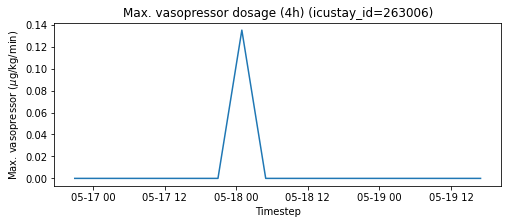

In [13]:
# Plot random patient
plot_single(data_all, key='max_vaso', title='Max. vasopressor dosage (%s)' % INTERVAL_TIME, ylabel='Max. vasopressor ($\mu$g/kg/min)', style='-')

---
## IV Fluids

#### 1. MetaVision

In [14]:
ivfluid_mv_df = read_csv(DATA_DIR + 'inputevents_mv_cohort.csv')

# Drop 14-Oral/Gastric Intake (i.e. having a glass of water)
condition = (ivfluid_mv_df['ordercategoryname'] != '14-Oral/Gastric Intake') & (ivfluid_mv_df['amountuom'] == 'ml')
ivfluid_mv_df = ivfluid_mv_df[condition]

# Sanity check: remove amounts outside (0, 5000) range
ivfluid_mv_df = ivfluid_mv_df[(ivfluid_mv_df['amount'] > 0) & (ivfluid_mv_df['amount'] < 5000)]

# Compute duration in hours
# Remark: original erroneously measured time in minutes
ivfluid_mv_df['duration'] = to_hours(ivfluid_mv_df['endtime'] - ivfluid_mv_df['starttime'])

# Drop unused columns
ivfluid_mv_df = ivfluid_mv_df[['subject_id', 'hadm_id', 'icustay_id', 'starttime', 'endtime', 'amount', 'duration']]
ivfluid_mv_df.head()

,subject_id,hadm_id,icustay_id,starttime,endtime,amount,duration
2,23,124321,234044.0,2157-10-21 15:00:00,2157-10-21 15:01:00,200.000000,0.016667
4,23,124321,234044.0,2157-10-21 12:15:00,2157-10-21 13:22:00,13.432238,1.116667
7,23,124321,234044.0,2157-10-21 17:08:00,2157-10-21 18:08:00,49.999999,1.000000
10,23,124321,234044.0,2157-10-22 08:00:00,2157-10-22 08:01:00,200.000000,0.016667
14,23,124321,234044.0,2157-10-22 09:24:00,2157-10-22 09:48:00,1.602968,0.400000


In order to determine the total amount of IV fluid administered within a 4 hour interval, we need to calculate how long a treatment was administered for during an interval; multiplied by the rate (i.e. `amount / duration`) we can infer the total amount administered by each treatment during the current interval. For this we use the `total_admin_in_interval` function below:

In [15]:
# Computes how much of each dose was administered between interval_start and interval_end
def total_admin_in_interval(interval_start, interval_end, treatments):
    dose_start = treatments['starttime']
    dose_end = treatments['endtime']
    amount = treatments['amount']
    duration = treatments['duration']
    rate = amount / duration # in ml/hour!   
    
    total_ml = 0
    
    # Option 1: Dose started before interval and ended after interval
    c1 = (dose_start < interval_start) & (dose_end > interval_end)
    if c1.any():
        total_ml += (to_hours(interval_end - interval_start) * rate[c1]).sum()
    
    # Option 2: Dose started before and ended within interval
    c2 = (dose_start < interval_start) & (dose_end > interval_start) & (dose_end <= interval_end)
    if c2.any():
        total_ml += (to_hours(dose_end - interval_start) * rate[c2]).sum()
    
    # Option 3: Dose started and ended in interval
    c3 = (dose_start >= interval_start) & (dose_start < interval_end) & (dose_end <= interval_end) & (dose_end > interval_start)
    if c3.any():
        total_ml += amount[c3].sum()
    
    # Option 4: dose started in interval and ended after interval
    c4 = (dose_start >= interval_start) & (dose_start < interval_end) & (interval_end < dose_end)
    if c4.any():
        total_ml += (to_hours(interval_end - dose_start) * rate[c4]).sum()
            
    return total_ml

We can now use `total_admin_in_interval()` on each interval `(interval_start, interval_end)` and treatment in `ivfluid_mv_df` to compute the total IV fluid administration within each 4 hour interval:

In [16]:
for icustay_id, treatments in tqdm(ivfluid_mv_df.groupby('icustay_id'), desc='Grab some coffee'):
    
    # Is icustay part of cohort?
    if icustay_id not in data_all:
        continue
    
    # Total fluid intake
    timesteps = icustay_timesteps[icustay_id]
    total_ivfluid = np.zeros(len(timesteps) - 1, dtype=np.float64)
    
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Compute total IV fluid
        total_ivfluid[i] = total_admin_in_interval(interval_start, interval_end, treatments)
        
    # Save!
    data_all[icustay_id]['total_iv_fluid'] = total_ivfluid
    
del ivfluid_mv_df

Grab some coffee: 100%|██████████████████████████████████████████████████████████| 13593/13593 [08:31<00:00, 26.59it/s]


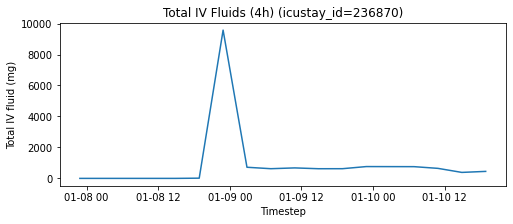

In [17]:
# Grab IV fluids from random patient
plot_single(data_all, key='total_iv_fluid', title='Total IV Fluids (%s)' % INTERVAL_TIME, ylabel='Total IV fluid (mg)', style='-')

#### Adding IV Fluid Running Total

In Roggeveen et al. an additional feature is incorporated which measures the total IC fluid administered up to the curren timestep. We implement this here using `np.cumsum`;

In [18]:
for icustay_id, icustay_data in data_all.items():
    if 'total_iv_fluid' in icustay_data.keys():
        data_all[icustay_id]['running_total_iv_fluid'] = np.cumsum(icustay_data['total_iv_fluid'])

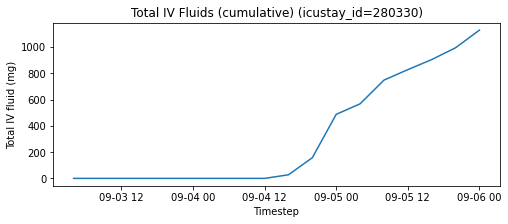

In [19]:
# Grab IV fluids from random patient
plot_single(data_all, key='running_total_iv_fluid', title='Total IV Fluids (cumulative)', ylabel='Total IV fluid (mg)', style='-')

---
## Vital functions

In [20]:
vitals_df = read_csv(DATA_DIR + 'vitals_cohort.csv')
vitals_df.head()

,subject_id,hadm_id,icustay_id,window_start,window_end,intime,outtime,charttime,vital_id,valuenum
0,4,185777,294638,2191-03-15,2191-03-18,2191-03-16 00:29:31,2191-03-17 16:46:31,2191-03-16 01:30:00,HeartRate,111.000000
1,4,185777,294638,2191-03-15,2191-03-18,2191-03-16 00:29:31,2191-03-17 16:46:31,2191-03-16 01:30:00,SpO2,98.000000
2,4,185777,294638,2191-03-15,2191-03-18,2191-03-16 00:29:31,2191-03-17 16:46:31,2191-03-16 01:30:00,TempC,37.444445
3,4,185777,294638,2191-03-15,2191-03-18,2191-03-16 00:29:31,2191-03-17 16:46:31,2191-03-16 02:00:00,DiasBP,63.000000
4,4,185777,294638,2191-03-15,2191-03-18,2191-03-16 00:29:31,2191-03-17 16:46:31,2191-03-16 02:00:00,HeartRate,100.000000


In [21]:
# Vitals recorded
ALL_VITALS = list(set(vitals_df['vital_id']))
print(ALL_VITALS)

['RespRate', 'MeanBP', 'SpO2', 'DiasBP', 'SysBP', 'HeartRate', 'TempC', 'Glucose']


<br>
As with the other measurements, we bin each of the vital measurements into intervals:

In [22]:
for icustay_id, measurements in tqdm(vitals_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    # Add keys for each vital_id to data_all with empty measurements vector
    timesteps = icustay_timesteps[icustay_id]
    for vital_id in ALL_VITALS:
        data_all[icustay_id][to_snakecase(vital_id)] = np.full(len(timesteps) - 1, np.nan)
            
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: Measurement `charttime` in (interval_start, interval_end)
        condition = (measurements['charttime'] > interval_start) & (measurements['charttime'] < interval_end)  
        
        # Compute average value of each vital_id
        vital_means = measurements[condition].groupby('vital_id')['valuenum'].mean()
        
        for vital_id, value in vital_means.items():
            data_all[icustay_id][to_snakecase(vital_id)][i] = value
            
del vitals_df

100%|████████████████████████████████████████████████████████████████████████████| 15606/15606 [06:23<00:00, 40.66it/s]


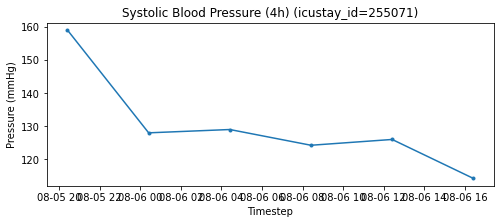

In [23]:
# Grab SysBP from random patient
plot_single(data_all, key='sys_bp', title='Systolic Blood Pressure (%s)' % INTERVAL_TIME, ylabel='Pressure (mmHg)')

---
## Lab results

In [24]:
lab_df = read_csv(DATA_DIR + 'labs_cohort.csv')

# Drop rows with NaNs
lab_df = lab_df.dropna(axis=0)

lab_df.head()

,subject_id,hadm_id,icustay_id,window_start,window_end,intime,outtime,charttime,lab_id,valuenum
0,4,185777,294638,2191-03-15,2191-03-18,2191-03-16 00:29:31,2191-03-17 16:46:31,2191-03-15 14:12:00,ALAT,28.0
1,4,185777,294638,2191-03-15,2191-03-18,2191-03-16 00:29:31,2191-03-17 16:46:31,2191-03-15 14:12:00,ANION GAP,17.0
2,4,185777,294638,2191-03-15,2191-03-18,2191-03-16 00:29:31,2191-03-17 16:46:31,2191-03-15 14:12:00,ASAT,69.0
3,4,185777,294638,2191-03-15,2191-03-18,2191-03-16 00:29:31,2191-03-17 16:46:31,2191-03-15 14:12:00,BICARBONATE,24.0
4,4,185777,294638,2191-03-15,2191-03-18,2191-03-16 00:29:31,2191-03-17 16:46:31,2191-03-15 14:12:00,BILIRUBIN,2.2


In [25]:
# Which hormones / fluids were measured?
ALL_LAB_IDS = list(set(lab_df['lab_id'].values))
print(ALL_LAB_IDS) 

['ALAT', 'BICARBONATE', 'HEMOGLOBIN', 'PLATELET', 'PTT', 'POTASSIUM', 'BaseExcess', 'CALCIUM', 'SODIUM', 'ION_CALCIUM', 'ASAT', 'ANION GAP', 'MAGNESIUM', 'BANDS', 'PT', 'PACO2', 'CHLORIDE', 'BUN', 'WBC', 'LACTATE', 'BILIRUBIN', 'PAO2', 'GLUCOSE', 'PH', 'CREATININE', 'ALBUMIN']


<br>
Like the vitals, we will bin the lab results into intervals;

In [26]:
for icustay_id, lab_results in tqdm(lab_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    # Add lab_ids to `data_all` to store aggregated lab measurements
    timesteps = icustay_timesteps[icustay_id]
    for lab_id in ALL_LAB_IDS:
        if lab_id not in data_all: # glucose is also measured more frequently as a vital
            data_all[icustay_id][to_snakecase(lab_id)] = np.full(len(timesteps) - 1, np.nan)
            
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: Measurement charttime in (interval_start, interval_end)
        condition = (lab_results['charttime'] > interval_start) & (lab_results['charttime'] <= interval_end)  
        
        # Compute average value of each lab_id
        lab_means = lab_results[condition].groupby('lab_id')['valuenum'].mean()
        
        for item_id, value in lab_means.items():
            data_all[icustay_id][to_snakecase(item_id)][i] = value
            
del lab_df

100%|████████████████████████████████████████████████████████████████████████████| 17106/17106 [06:56<00:00, 41.02it/s]


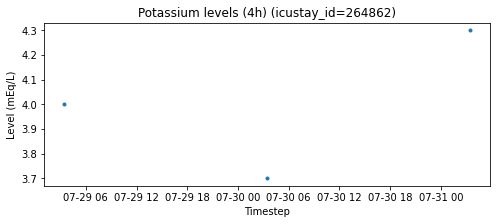

In [27]:
# Grab Leukocyte count from random patient
plot_single(data_all, key='potassium', title='Potassium levels (%s)' % INTERVAL_TIME, ylabel='Level (mEq/L)', style='.-')

Note how many missing values we have, i.e. gaps in the plot above, even when we plot the most frequently measured lab item (`potassium`) and bin these measurements into intervals of 4 hours.

---
## Urine Output

In [28]:
urine_df = read_csv(DATA_DIR + 'urineoutput_cohort.csv')

# Sanity check: drop values exceeding 5000
urine_df = urine_df[(urine_df['value'] > 0) & (urine_df['value'] < 5000)]

urine_df.head()

,subject_id,hadm_id,icustay_id,charttime,value
0,20944,177500,205353,2140-12-01 02:00:00,5.0
1,15185,120114,210804,2132-06-03 08:00:00,100.0
2,11483,180774,236794,2100-11-01 01:00:00,150.0
3,10624,151346,247650,2141-08-23 18:00:00,160.0
4,9021,178275,233215,2167-07-28 07:00:00,45.0


In [29]:
for icustay_id, measurements in tqdm(urine_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in data_all:
        continue
        
    # Add lab_ids to `data_all` to store aggregated lab measurements
    timesteps = icustay_timesteps[icustay_id]
    data_all[icustay_id]['total_urine_output'] = np.full(len(timesteps) - 1, np.nan)
            
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: Measurement charttime in (interval_start, interval_end)
        condition = (measurements['charttime'] > interval_start) & (measurements['charttime'] <= interval_end)  
        
        # Compute total value within timestep
        data_all[icustay_id]['total_urine_output'][i] = measurements[condition]['value'].sum()
        
del urine_df

100%|████████████████████████████████████████████████████████████████████████████| 15024/15024 [03:22<00:00, 74.35it/s]


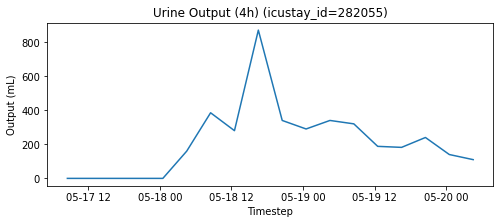

In [30]:
# Grab urine output from random patient
plot_single(data_all, key='total_urine_output', title='Urine Output (%s)' % INTERVAL_TIME, ylabel='Output (mL)', style='-')

#### Running Total Urine Output

In Roggeveen et al. an additional feature `running_total_urine_output` is included into the feature set; we add this feature here using `np.cumsum`;

In [31]:
for icustay_id, icustay_data in data_all.items():
    if 'total_urine_output' in icustay_data.keys():
        data_all[icustay_id]['running_total_urine_output'] = np.cumsum(icustay_data['total_urine_output'])

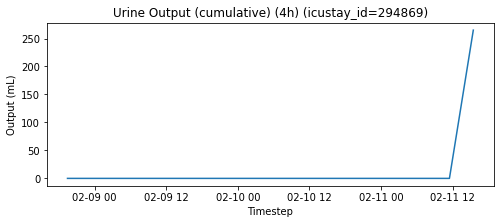

In [32]:
# Grab urine output from random patient
plot_single(data_all, key='running_total_urine_output', title='Urine Output (cumulative) (%s)' % INTERVAL_TIME, ylabel='Output (mL)', style='-')

---
## FiO2 (Fraction of Inspired Oxygen)

In [33]:
fio2_df = read_csv(DATA_DIR + 'fio2_cohort.csv')
fio2_df.head()

,subject_id,hadm_id,icustay_id,charttime,fio2
0,4,185777,294638,2191-03-16 03:00:00,94.999999
1,4,185777,294638,2191-03-16 08:00:00,50.000000
2,4,185777,294638,2191-03-16 11:00:00,NaN
3,9,150750,220597,2149-11-09 13:40:00,NaN
4,9,150750,220597,2149-11-09 17:00:00,60.000002


In [34]:
# Process ICU stays one-by-one
for icustay_id, measurements in tqdm(fio2_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    # Add lab_ids to `data_all` to store aggregated lab measurements
    timesteps = icustay_timesteps[icustay_id]
    data_all[icustay_id]['fi_o2'] = np.full(len(timesteps) - 1, np.nan)
            
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: Measurement charttime in (interval_start, interval_end)
        condition = (measurements['charttime'] > interval_start) & (measurements['charttime'] <= interval_end)  
        
        # Compute average value within timestep
        data_all[icustay_id]['fi_o2'][i] = measurements[condition]['fio2'].mean()
        
del fio2_df

100%|████████████████████████████████████████████████████████████████████████████| 10215/10215 [02:18<00:00, 73.90it/s]


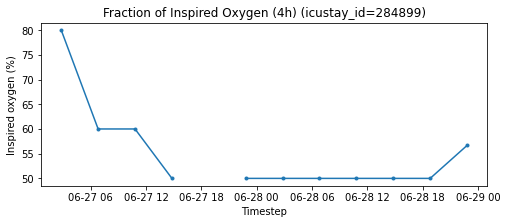

In [35]:
# Grab FiO2 from random patient
plot_single(data_all, key='fi_o2', title='Fraction of Inspired Oxygen (%s)' % INTERVAL_TIME, ylabel='Inspired oxygen (%)')

---
## Demographics

In [36]:
demo_df = pd.read_csv(DATA_DIR + 'demographics_cohort.csv')
demo_df.head()

,subject_id,hadm_id,icustay_id,age,is_male,race_white,race_black,race_hispanic,race_other,height,...,vent,sofa,lods,sirs,qsofa,qsofa_sysbp_score,qsofa_gcs_score,qsofa_resprate_score,elixhauser_hospital,blood_culture_positive
0,27513,163557,200003,48.2940,1,1,0,0,0,177.80,...,1,6,3,4,2,1.0,0.0,1.0,0,1
1,9514,127229,200014,84.7274,1,0,0,0,1,167.64,...,1,3,5,4,2,1.0,0.0,1.0,0,1
2,21789,112486,200019,82.8820,0,1,0,0,0,NaN,...,1,5,7,3,2,0.0,1.0,1.0,0,1
3,14987,165426,200030,54.1915,1,0,1,0,0,187.96,...,0,7,4,4,2,1.0,0.0,1.0,9,1
4,46489,152416,200035,30.6591,1,0,1,0,0,NaN,...,0,2,1,3,1,0.0,0.0,1.0,2,0


In [37]:
# Define demographics and disease severity scores of interest (on admission)
DEMOGRAPHICS_COLS = ['age', 'height', 'is_male', 'weight', 'vent', 'sofa', 'sirs']

In [38]:
for icustay_id, demographics in tqdm(demo_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    timesteps = icustay_timesteps[icustay_id]
    N = len(timesteps) - 1
    
    for feature in DEMOGRAPHICS_COLS:
        data_all[icustay_id][feature] = np.ones(N) * demographics[feature].values[0]
        
del demo_df

100%|██████████████████████████████████████████████████████████████████████████| 18346/18346 [00:07<00:00, 2340.97it/s]


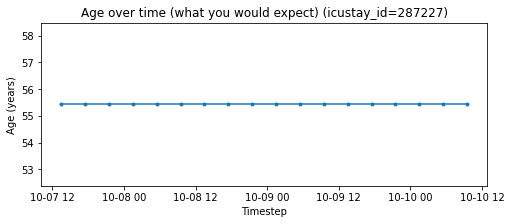

In [39]:
plot_single(data_all, key='age', title='Age over time (what you would expect)', ylabel='Age (years)')

---
# Putting It All Together!

## Add Reward
We define positive terminal reward (R=15) as discharge of patient (survival beyond hospital stay) and negative reward (R=-15) by in-hospital mortality (i.e. did the patient pass away during ICU admission). No intermediate rewards are issued.

In [40]:
# Dict mapping from patient to 30-day mortality
mortality_dct = {row['icustay_id']:row['hospital_expire_flag'] for _, row in cohort_df.iterrows()}

# Process ICU stays one-by-one
for icustay_id, patient in tqdm(cohort_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    # Determine whether person passed away in hospital
    timesteps = icustay_timesteps[icustay_id]
    deceased = mortality_dct[icustay_id]
    
    # Define reward as +15 if survived; -15 otherwise; no intermediate rewards
    rewards = np.zeros(len(timesteps) - 1)
    rewards[-1] = 15 if not deceased else -15
    
    data_all[icustay_id]['reward'] = rewards

100%|█████████████████████████████████████████████████████████████████████████| 18091/18091 [00:00<00:00, 37592.99it/s]


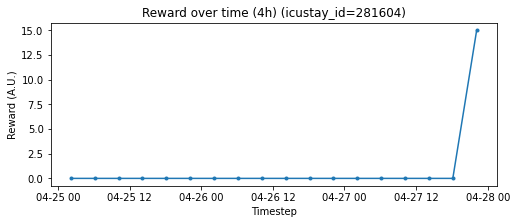

In [41]:
# Grab Reward trajectory from random patient
plot_single(data_all, key='reward', title='Reward over time (%s)' % INTERVAL_TIME, ylabel='Reward (A.U.)')

## Shift Actions in Time by One Timestep
By dropping the first value (and appending a `NaN` at the end) we effectively shift the reward signal, vasopressor doses and IV fluid intake one time-step back (giving us a state representation, action and the associated reward all in the same DataFrame row);

In [42]:
for icustay_id, icustay_data in data_all.items():
    
    # Shift actions and reward sequence forward by one
    if 'total_iv_fluid' in data_all[icustay_id]:
        data_all[icustay_id]['total_iv_fluid_shifted'] = list(data_all[icustay_id]['total_iv_fluid'][1:]) + [np.NaN]
        
    if 'max_vaso' in data_all[icustay_id]:
        data_all[icustay_id]['max_vaso_shifted'] = list(data_all[icustay_id]['max_vaso'][1:]) + [np.NaN]
        
    if 'reward' in data_all[icustay_id]:
        data_all[icustay_id]['reward_shifted'] = list(data_all[icustay_id]['reward'][1:]) + [np.NaN]
        
print('Done!')

Done!


## Convert to DataFrame!

In [43]:
# Mark measurement by decision time `interval_end` (i.e. drop interval_start)
for icustay_id in data_all.keys():
    data_all[icustay_id]['timestep'] = data_all[icustay_id]['timestep'][1:]

# Convert individual streams into DataFrames
data_all_df = {icustay_id: pd.DataFrame.from_dict(icustay_data) for icustay_id, icustay_data in data_all.items()}

# Add icustay_id as identifier
for icustay_id in data_all_df.keys():
    data_all_df[icustay_id]['icustay_id'] = icustay_id
    
# Merge into one large DataFrame
data_all_df = pd.concat(data_all_df.values()).reset_index()
data_all_df.head()

,index,timestep,total_iv_fluid,running_total_iv_fluid,resp_rate,mean_bp,sp_o2,dias_bp,sys_bp,heart_rate,...,weight,vent,sofa,sirs,reward,total_iv_fluid_shifted,reward_shifted,icustay_id,max_vaso,max_vaso_shifted
0,0,2122-04-13 01:35:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,99.2,0.0,5.0,4.0,0.0,0.0,0.0,226090,NaN,NaN
1,1,2122-04-13 05:35:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,99.2,0.0,5.0,4.0,0.0,0.0,0.0,226090,NaN,NaN
2,2,2122-04-13 09:35:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,99.2,0.0,5.0,4.0,0.0,0.0,0.0,226090,NaN,NaN
3,3,2122-04-13 13:35:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,99.2,0.0,5.0,4.0,0.0,0.0,0.0,226090,NaN,NaN
4,4,2122-04-13 17:35:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,99.2,0.0,5.0,4.0,0.0,0.0,0.0,226090,NaN,NaN


In [44]:
# For conversion rates see https://github.com/LucaMD/SRL/blob/master/SEPSIS/MIMIC_src/MIMIC_R_DataPreprocessing.ipynb
data_final_df = pd.DataFrame({'icustay_id': data_all_df['icustay_id'], 
                              'timestep': data_all_df['timestep'], 
                              # Discretized 'action' (0 - 24) added below
                              'max_vp': data_all_df['max_vaso'],
                              'max_vp_shifted': data_all_df['max_vaso_shifted'],
                              'total_iv_fluid': data_all_df['total_iv_fluid'],
                              'total_iv_fluid_shifted': data_all_df['total_iv_fluid_shifted'],
                              'reward': data_all_df['reward_shifted'],
                              'sirs_score': data_all_df['sirs'],
                              'sofa_score': data_all_df['sofa'],
                              'weight': data_all_df['weight'],
                              'ventilator': data_all_df['vent'],
                              'height': data_all_df['height'],
                              'age': data_all_df['age'],
                              'gender': data_all_df['is_male'],
                              'heart_rate': data_all_df['heart_rate'],
                              'temp': data_all_df['temp_c'],
                              'mean_bp': data_all_df['mean_bp'],
                              'dias_bp': data_all_df['dias_bp'],
                              'sys_bp': data_all_df['sys_bp'],
                              'resp_rate': data_all_df['resp_rate'],
                              'spo2': data_all_df['sp_o2'],
                              'natrium': data_all_df['sodium'],
                              'chloride': data_all_df['chloride'],
                              'kalium': data_all_df['potassium'],
                              'trombo': data_all_df['platelet'],
                              'leu': data_all_df['wbc'],
                              'anion_gap': data_all_df['anion gap'],
                              'aptt': data_all_df['ptt'],
                              'art_ph': data_all_df['ph'],
                              'asat': data_all_df['asat'],
                              'alat': data_all_df['alat'],
                              'bicarbonaat': data_all_df['bicarbonate'],
                              'art_be': data_all_df['base_excess'],
                              'ion_ca': data_all_df['ion_calcium'],
                              'lactate': data_all_df['lactate'],
                              'paco2': data_all_df['paco2'],
                              'pao2': data_all_df['pao2'],
                              'fio2': data_all_df['fi_o2'],
                              'sirs_bands': data_all_df['bands'], # Not part of feature space
                              'shock_index': data_all_df['heart_rate'] / data_all_df['sys_bp'],
                              'hb': data_all_df['hemoglobin'] * 0.6206, # Conversion rates (see original notebook)
                              'bilirubin': data_all_df['bilirubin'] * (1 / 0.05847953),
                              'creatinine': data_all_df['creatinine'] * (1 / 0.01131222),
                              'inr': data_all_df['pt'] / 12,
                              'ureum': data_all_df['bun'] * 0.3571,
                              'albumin': data_all_df['albumin'] * 10,
                              'magnesium': data_all_df['magnesium'] * 0.411,
                              'calcium': data_all_df['calcium'] * 0.25,
                              'pf_ratio': data_all_df['paco2'] / data_all_df['fi_o2'],
                              'glucose': data_all_df['glucose'] * 0.0555,
                              'running_total_urine_output': data_all_df['running_total_urine_output'],
                              'total_urine_output': data_all_df['total_urine_output'],
                              'running_total_iv_fluid': data_all_df['running_total_iv_fluid'],})

In [45]:
# Grab data from random patient
icustay_id = random.choice(list(set(data_all.keys())))
data_final_df[data_final_df['icustay_id'] == icustay_id].tail()

,icustay_id,timestep,max_vp,max_vp_shifted,total_iv_fluid,total_iv_fluid_shifted,reward,sirs_score,sofa_score,weight,...,inr,ureum,albumin,magnesium,calcium,pf_ratio,glucose,running_total_urine_output,total_urine_output,running_total_iv_fluid
136291,289716,2100-09-06 07:36:00,NaN,NaN,0.0,0.0,0.0,4.0,4.0,119.0,...,1.058333,8.2133,NaN,0.8631,2.05,NaN,7.437,407.0,0.0,2337.166663
136292,289716,2100-09-06 11:36:00,NaN,NaN,0.0,0.0,0.0,4.0,4.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,407.0,0.0,2337.166663
136293,289716,2100-09-06 15:36:00,NaN,NaN,0.0,0.0,0.0,4.0,4.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,407.0,0.0,2337.166663
136294,289716,2100-09-06 19:36:00,NaN,NaN,0.0,0.0,-15.0,4.0,4.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,407.0,0.0,2337.166663
136295,289716,2100-09-06 23:36:00,NaN,NaN,0.0,NaN,NaN,4.0,4.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,407.0,0.0,2337.166663


## Discretize Action Space

In [46]:
# Compute 5-bin histogram to obtain discrete intervals
def get_quantile_intervals(vals):
    vals = vals[vals > 0].values
    return [0] + [np.nanquantile(vals, i) for i in np.linspace(0, 1, 5)]

max_vp_bins = get_quantile_intervals(data_final_df['max_vp_shifted'])
tot_iv_bins = get_quantile_intervals(data_final_df['total_iv_fluid_shifted'])

print('Max. vasopressor bins:', max_vp_bins)
print('Intr. (IV) fluid bins:', tot_iv_bins)

Max. vasopressor bins: [0, 0.0020024486, 0.11255290609499999, 0.2250900315, 0.450300370095, 222.731249999985]
Intr. (IV) fluid bins: [0, 0.04251798799999999, 162.55157171429997, 500.0, 1076.09715336875, 25332.742653704]


In [47]:
# Replace NaNs by zero (no vasopressor or IV fluid treatment, so dose = zero)
data_final_df['max_vp'] = data_final_df['max_vp'].fillna(0)
data_final_df['total_iv_fluid'] = data_final_df['total_iv_fluid'].fillna(0)
data_final_df['max_vp_shifted'] = data_final_df['max_vp_shifted'].fillna(0)
data_final_df['total_iv_fluid_shifted'] = data_final_df['total_iv_fluid_shifted'].fillna(0)

# Use pd.cut to discretize actions
max_vp_discrete = pd.cut(data_final_df['max_vp_shifted'], 
                         bins=max_vp_bins, 
                         labels=[0, 1, 2, 3, 4], 
                         include_lowest=True).astype(float)

total_iv_discrete = pd.cut(data_final_df['total_iv_fluid_shifted'], 
                           bins=tot_iv_bins, 
                           labels=[0, 1, 2, 3, 4], 
                           include_lowest=True).astype(float)

# Compute action as 5 * total_iv_fluid + max_vaso
data_final_df['action'] = 5 * total_iv_discrete + max_vp_discrete
data_final_df.head()

,icustay_id,timestep,max_vp,max_vp_shifted,total_iv_fluid,total_iv_fluid_shifted,reward,sirs_score,sofa_score,weight,...,ureum,albumin,magnesium,calcium,pf_ratio,glucose,running_total_urine_output,total_urine_output,running_total_iv_fluid,action
0,226090,2122-04-13 01:35:00,0.0,0.0,0.0,0.0,0.0,4.0,5.0,99.2,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1,226090,2122-04-13 05:35:00,0.0,0.0,0.0,0.0,0.0,4.0,5.0,99.2,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2,226090,2122-04-13 09:35:00,0.0,0.0,0.0,0.0,0.0,4.0,5.0,99.2,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
3,226090,2122-04-13 13:35:00,0.0,0.0,0.0,0.0,0.0,4.0,5.0,99.2,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
4,226090,2122-04-13 17:35:00,0.0,0.0,0.0,0.0,0.0,4.0,5.0,99.2,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


#### Export Action Bins

In [48]:
# Save bin edges of max_vaso and total_iv_fluid as .npy files for later reference
with open(OUTPUT_DIR + 'max_vaso_bins.npy', 'w') as file:
    np.savetxt(file, max_vp_bins)
    
with open(OUTPUT_DIR + 'total_iv_fluid_bins.npy', 'w') as file:
    np.savetxt(file, tot_iv_bins)
    
print('Done!')

Done!


#### Export Map from Actions to IV/Vaso Bins

In [49]:
# Save mapping from action indices (0 to 24) to bin indices (0 to 4)
action_id_to_bins = dict()
for max_vaso in range(5):
    for total_iv_fluid in range(5):
        action_id_to_bins[5 * total_iv_fluid + max_vaso] = (total_iv_fluid, max_vaso)

with open(OUTPUT_DIR + 'action_to_vaso_fluid_bins.pkl', 'wb') as file:
    pickle.dump(action_id_to_bins, file)
print('Done!')

Done!


## Disease Severity Scores (SOFA, qSOFA, SIRS)
For evaluation it is useful to consider not just (q)SOFA scores on admission (see `demographics_cohort.csv`), but also at each state (where possible). This will allow us to analyze the actions taken by the model as a function of disease progression.

In [50]:
# TODO: SOFA and qSOFA (how to get gcs?)

def SIRS(df):
    # Check if all quantities we need are there
    missing = df['temp'].isna() | df['heart_rate'].isna() | (df['resp_rate'].isna() & df['paco2'].isna()) | (df['leu'].isna() & df['sirs_bands'].isna())
    missing = missing.values
    
    # SIRS conditions
    temp = (df['temp'] < 36) | (df['temp'] > 38)
    heart_rate = df['heart_rate'] > 90
    resp_rate = (df['resp_rate'] > 20) | (df['paco2'] < 32)
    leukocytes = (df['leu'] > 12000) | (df['leu'] < 4000) | (df['sirs_bands'] > 10)
    
    # Total SIRS score
    sirs = temp.astype(int) + heart_rate.astype(int) + resp_rate.astype(int) + leukocytes.astype(int)
    sirs = sirs.values
        
    return np.where(missing, -np.ones(sirs.shape), sirs) # -1 in case not computable


data_final_df['state_sirs'] = SIRS(data_final_df)

<AxesSubplot:>

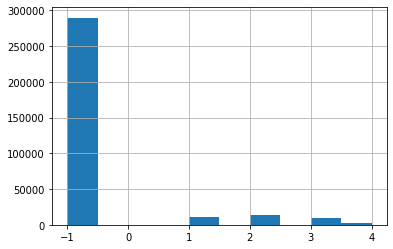

In [51]:
data_final_df['state_sirs'].hist()

## Cap Outlying Measurements

During exploratory data analysis it was found that the data was riddled with measurement errors, whereby treatment and vital parameters would take values orders in magnitude higher than would be possible (or safe). To ensure feature normalization can take place correctly, we will cap values to their respective mimum or maximum when outside of their clinically possible range.

However, slight modifications are made to the capping values used in (Roggeveen et al., 2021)
1. Max. `anion_gap`: 12 $\rightarrow$ 40 (as 12 can be considered an acceptable value for even healthy patients depending on the lab and how the test was performed, see [Wikipedia's entry for Anion Gap](https://en.wikipedia.org/wiki/Anion_gap))
2. Min. `shock_index`: 0.5 $\rightarrow$ 0.4 (a value of 0.5 was very often measured (>22.000) and thus the range was slightly relaxed compared to Roggeveen et al.)

In [75]:
# Load capping values (roggeveen et al., 2021)
min_max_values = pd.read_csv('capping_values.csv').set_index('parameter').to_dict('index')

for feature, rng in min_max_values.items():
    # Cap values with bounds specific to feature
    capped_values = data_final_df[feature].clip(lower=rng['minval'], upper=rng['maxval'])
        
    # Count non-NaN measurements capped
    num_capped = ((capped_values != data_final_df[feature]) * capped_values.notna()).sum()
    print(feature, num_capped)
    
    data_final_df[feature] = capped_values

age 432
alat 2
albumin 0
anion_gap 66
aptt 251
art_be 1
art_ph 2
asat 2
bicarbonaat 0
bilirubin 123
calcium 159
chloride 199
creatinine 33
dias_bp 41
fio2 20
glucose 297
hb 3
heart_rate 2
height 378
inr 0
ion_ca 11
kalium 7
lactate 0
leu 234
magnesium 157
mean_bp 13
natrium 87
paco2 1095
pao2 3324
pf_ratio 21
resp_rate 206
running_total_urine_output 0
running_total_iv_fluid 33
shock_index 690
sirs_score 0
sofa_score 0
spo2 2
sys_bp 2
temp 0
total_iv_fluid 1
total_urine_output 1
trombo 1
ureum 0
weight 1710


## Training, Validation and Test

To train and test the model we need dedicated training, validation (e.g. for hyperparameter tuning) and test sets. We perform the splitting below;

In [76]:
# For reproduction sake!
random.seed(10)

In [77]:
# Specify fraction of ICU-stays for training, validation and testing
frac_train = 0.7
frac_valid = 0.1

# Randomly assign icustay_ids to train, val and test
icustay_ids = list(set(data_final_df['icustay_id']))
random.shuffle(icustay_ids)

num_train = int(len(icustay_ids) * frac_train)
num_valid = int(len(icustay_ids) * frac_valid)

train_icustays = icustay_ids[:num_train]
valid_icustays = icustay_ids[num_train:num_train + num_valid]
test_icustays = icustay_ids[num_train + num_valid:]

# Store train/valid/test icustay_ids
np.savetxt(OUTPUT_DIR + 'mimic-iii_icustay_ids_train.npy', train_icustays)
np.savetxt(OUTPUT_DIR + 'mimic-iii_icustay_ids_valid.npy', valid_icustays)
np.savetxt(OUTPUT_DIR + 'mimic-iii_icustay_ids_test.npy', test_icustays)

print('Dataset instances:')
print('Train  %s' % len(train_icustays))
print('Valid  %s' % len(valid_icustays))
print('Test   %s' % len(test_icustays))

Dataset instances:
Train  12663
Valid  1809
Test   3619


In [78]:
data_train_df = data_final_df[data_final_df['icustay_id'].isin(train_icustays)].reset_index(drop=True)
data_valid_df = data_final_df[data_final_df['icustay_id'].isin(valid_icustays)].reset_index(drop=True)
data_test_df = data_final_df[data_final_df['icustay_id'].isin(test_icustays)].reset_index(drop=True)
print('Train/valid/test split done!')

Train/valid/test split done!


## Feature Normalization
In order to work well with neurla networks we may wish to normlize the input and perform various kinds of transformations (e.g. log transforms). Here we follow Roggeveen et al. and perform the normalization and transformation using a set of *clinically-guided transformations*;

In [79]:
BINARY_FIELDS = ['ventilator', 'gender']
LOG_FIELDS = ['max_vaso', 'spo2', 'ureum', 'creatinine', 'alat', 'asat', 'bilirubin', 'inr', 'running_total_iv_fluid',
              'total_iv_fluid', 'running_total_urine_output', 'total_urine_output']
EXCLUDE = ['icustay_id', 'timestep', 'reward', 'state_sirs', 'action']

### Z-scoring and Log-transforms

In [80]:
# Compute training set averages and stdevs
avgs, stds = dict(), dict()
for col in data_train_df.columns:
    if col not in EXCLUDE:
        avgs[col] = data_train_df[col].mean() # training set mean
        stds[col] = data_train_df[col].std()  # training set std

# Perform normalization with values from data_train_df
for df in [data_train_df, data_valid_df, data_test_df]:
    for col in tqdm(df.columns):
        if col not in EXCLUDE:
            if col in BINARY_FIELDS:
                # Binary
                df[col] = df[col] - 0.5
            elif col in LOG_FIELDS:
                # Log
                df[col] = np.log(0.1 + df[col])
            else:
                # Linear
                df[col] = (df[col] - avgs[col]) / stds[col]
print('Transformations done!')

100%|█████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 897.56it/s]

Transformations done!


### MinMax Normalization
After Z-scoring Roggeveen et al. scales all features using MinMax normalization, which we will repeat for good measure (Although it undoes some of the previous normalization steps);

In [81]:
for col in tqdm(df.columns):
    if col not in EXCLUDE:
        # Min/max estimates from training set!
        train_min = data_train_df[col].min()
        train_max = data_train_df[col].max()
        
        data_train_df[col] = (data_train_df[col] - train_min) / (train_max - train_min)
        data_valid_df[col] = (data_valid_df[col] - train_min) / (train_max - train_min)
        data_test_df[col] = (data_test_df[col] - train_min) / (train_max - train_min)
print('Normalization done!')

100%|█████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 112.59it/s]

Normalization done!


In [61]:
data_train_df.head()

,icustay_id,timestep,max_vp,max_vp_shifted,total_iv_fluid,total_iv_fluid_shifted,reward,sirs_score,sofa_score,weight,...,albumin,magnesium,calcium,pf_ratio,glucose,running_total_urine_output,total_urine_output,running_total_iv_fluid,action,state_sirs
0,218267,2171-07-09 15:40:00,0.0,0.0,0.0,0.0,0.0,0.75,0.1,0.149615,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1.0
1,218267,2171-07-09 19:40:00,0.0,0.0,0.0,0.0,0.0,0.75,0.1,0.149615,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1.0
2,218267,2171-07-09 23:40:00,0.0,0.0,0.0,0.0,0.0,0.75,0.1,0.149615,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1.0
3,218267,2171-07-10 03:40:00,0.0,0.0,0.0,0.0,0.0,0.75,0.1,0.149615,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1.0
4,218267,2171-07-10 07:40:00,0.0,0.0,0.0,0.0,0.0,0.75,0.1,0.149615,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1.0


## Imputation

### Linear Interpolation
As sometimes only single points are missing between otherwise adjacent measurements we use linear interpolation to fill in these gaps. This prevents the possibility of th kNN imputer (next up) to add noise to these fairly certain values.

In [82]:
INTERP_COLS = ['glucose', 'hb', 'albumin', 'sys_bp', 'art_ph', 'total_urine_output', 'resp_rate', 'bicarbonaat',
               'aptt', 'ureum', 'temp', 'magnesium', 'trombo', 'pao2', 'asat', 'shock_index', 'heart_rate',
               'dias_bp', 'alat', 'sirs_bands', 'creatinine', 'ion_ca', 'art_be', 'paco2', 'inr', 'mean_bp',
               'kalium', 'natrium', 'pf_ratio', 'spo2', 'running_total_urine_output', 'leu', 'lactate', 
               'bilirubin', 'calcium', 'sofa_score', 'chloride', 'anion_gap']

# Interpolate each feature within each ICU stay separately for each dataset
for dataset in [data_train_df, data_valid_df, data_test_df]:
    groups = dataset.groupby('icustay_id', sort=False)
    for col in tqdm(INTERP_COLS):
        dataset[col] = groups[col].apply(lambda group: group.interpolate(method='linear', limit_area='inside', limit=1)) # Max 2 steps apart!
    
data_train_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:51<00:00,  1.34s/it]


,icustay_id,timestep,max_vp,max_vp_shifted,total_iv_fluid,total_iv_fluid_shifted,reward,sirs_score,sofa_score,weight,...,albumin,magnesium,calcium,pf_ratio,glucose,running_total_urine_output,total_urine_output,running_total_iv_fluid,action,state_sirs
0,218267,2171-07-09 15:40:00,0.0,0.0,0.0,0.0,0.0,0.75,0.1,0.149615,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1.0
1,218267,2171-07-09 19:40:00,0.0,0.0,0.0,0.0,0.0,0.75,0.1,0.149615,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1.0
2,218267,2171-07-09 23:40:00,0.0,0.0,0.0,0.0,0.0,0.75,0.1,0.149615,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1.0
3,218267,2171-07-10 03:40:00,0.0,0.0,0.0,0.0,0.0,0.75,0.1,0.149615,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1.0
4,218267,2171-07-10 07:40:00,0.0,0.0,0.0,0.0,0.0,0.75,0.1,0.149615,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1.0


### KNN-based Imputation
Some points that are missing lie 'outside' of the measurements (i.e. there is no point to the left or right) or multiple-adjacent values are missing. As there is significant uncertainty with these values we use kNN-based imputation to estimate their value.

In [83]:
IMPUTING_FIELDS = list(set(data_train_df.columns) - set(EXCLUDE))

# Training
for icustay_id in tqdm(train_icustays):
    X_incomplete = data_train_df.loc[data_train_df['icustay_id'] == icustay_id][IMPUTING_FIELDS]
    data_train_df.loc[data_train_df['icustay_id'] == icustay_id, IMPUTING_FIELDS] = KNN(k=3, verbose=False).fit_transform(X_incomplete)
    
# Validation
for icustay_id in tqdm(valid_icustays):
    X_incomplete = data_valid_df.loc[data_valid_df['icustay_id'] == icustay_id][IMPUTING_FIELDS]
    data_valid_df.loc[data_valid_df['icustay_id'] == icustay_id, IMPUTING_FIELDS] = KNN(k=3, verbose=False).fit_transform(X_incomplete)
    
# Test
for icustay_id in tqdm(test_icustays):
    X_incomplete = data_test_df.loc[data_test_df['icustay_id'] == icustay_id][IMPUTING_FIELDS]
    data_test_df.loc[data_test_df['icustay_id'] == icustay_id, IMPUTING_FIELDS] = KNN(k=3, verbose=False).fit_transform(X_incomplete)

data_train_df.head()

100%|██████████████████████████████████████████████████████████████████████████████| 3619/3619 [01:46<00:00, 33.84it/s]


,icustay_id,timestep,max_vp,max_vp_shifted,total_iv_fluid,total_iv_fluid_shifted,reward,sirs_score,sofa_score,weight,...,albumin,magnesium,calcium,pf_ratio,glucose,running_total_urine_output,total_urine_output,running_total_iv_fluid,action,state_sirs
0,218267,2171-07-09 15:40:00,0.0,0.0,0.0,0.0,0.0,0.75,0.1,0.149615,...,0.0,0.251174,0.48865,0.0,0.210702,0.0,0.0,0.0,0.0,-1.0
1,218267,2171-07-09 19:40:00,0.0,0.0,0.0,0.0,0.0,0.75,0.1,0.149615,...,0.0,0.251174,0.48865,0.0,0.210702,0.0,0.0,0.0,0.0,-1.0
2,218267,2171-07-09 23:40:00,0.0,0.0,0.0,0.0,0.0,0.75,0.1,0.149615,...,0.0,0.251174,0.48865,0.0,0.210702,0.0,0.0,0.0,0.0,-1.0
3,218267,2171-07-10 03:40:00,0.0,0.0,0.0,0.0,0.0,0.75,0.1,0.149615,...,0.0,0.251174,0.48865,0.0,0.210702,0.0,0.0,0.0,0.0,-1.0
4,218267,2171-07-10 07:40:00,0.0,0.0,0.0,0.0,0.0,0.75,0.1,0.149615,...,0.0,0.251174,0.48865,0.0,0.210702,0.0,0.0,0.0,0.0,-1.0


## Exclude Patients with Missing Data

Often patients have missing values, however in some cases patients may not have any data at all. As this will throw off the learning algorithm, we discard these patients, assuming that at least a few data points are measured for each feature.

In [123]:
def exclude_no_data(df, missing_threshold=.6):
    # Compute for all admissions the percentage of columns without values (i.e. zero deviation)
    perc_columns_no_data = (df.groupby('icustay_id').mad() == 0).mean(axis=1)
    
    # Drop admissions with more than 60% of features not recorded
    discard_ids = perc_columns_no_data.index[perc_columns_no_data > missing_threshold]
    
    return df[~df['icustay_id'].isin(discard_ids.values)]
    

data_train_df = exclude_no_data(data_train_df)
print('done!')
data_valid_df = exclude_no_data(data_valid_df)
print('done!')
data_test_df = exclude_no_data(data_test_df)
print('done!')

## Export Datasets

In [124]:
# Don't forget to save!!
data_train_df.to_csv(OUTPUT_DIR + 'mimic-iii_train.csv', index=False)
data_valid_df.to_csv(OUTPUT_DIR + 'mimic-iii_valid.csv', index=False)
data_test_df.to_csv(OUTPUT_DIR + 'mimic-iii_test.csv', index=False)
print('Done!')

Done!


#### Expected Memory Usage

In [125]:
# Size of current dataset with current ICU stays
full_df_gigs = data_final_df.memory_usage(deep=True).sum() / (1 << 30)
num_icustay_ids = len(set(data_final_df['icustay_id']))
print('Number of ICU-stay ids:', num_icustay_ids)

# Expected GB of whole 40.000 ICU stays in MIMIC-III
exp_gigs = 40000 * full_df_gigs / num_icustay_ids

print('Expected memory usage of dataset: %sGB' % round(exp_gigs, 2)) 

Number of ICU-stay ids: 18091
Expected memory usage of dataset: 0.3GB


---

## Done!

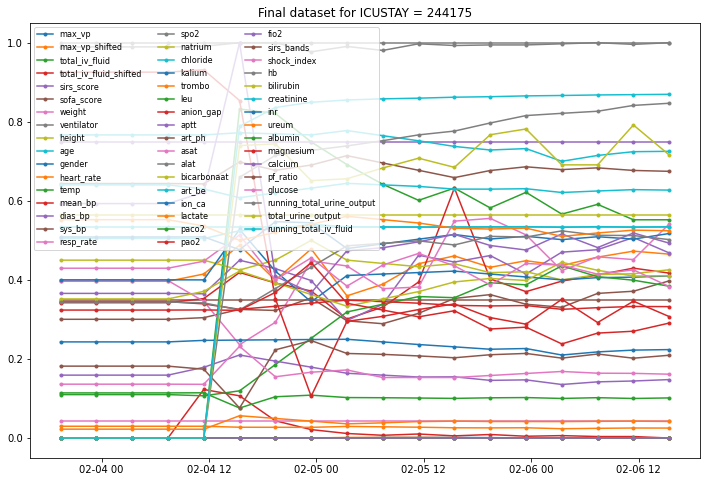

In [150]:
# Limit plot to one ICU stay
icustay_id = random.choice(list(set(data_train_df['icustay_id'])))
icustay_df = data_train_df[data_train_df['icustay_id'] == icustay_id]

# Plot interesting columns
plt.figure(figsize=(12, 8))
for col in icustay_df.columns:
    if col not in EXCLUDE:
        plt.plot(icustay_df['timestep'], icustay_df[col], label=col, marker='.')
        
plt.title('Final dataset for ICUSTAY = %s' % icustay_id)
plt.legend(ncol=3, prop={'size': 8})
plt.show()

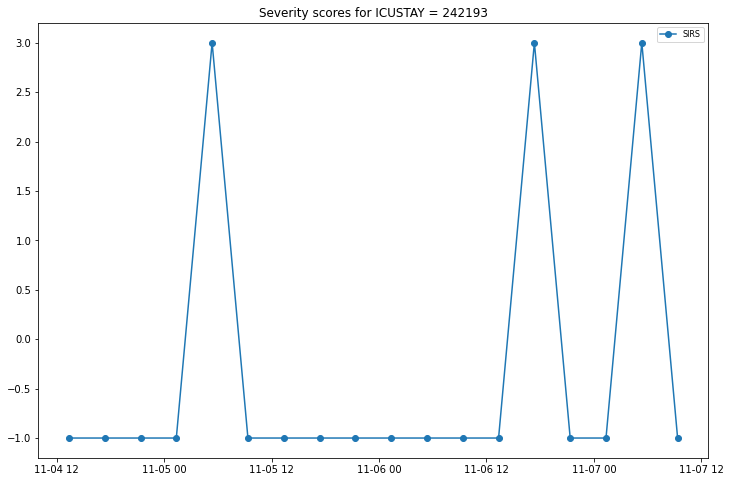

In [145]:
# Limit plot to one ICU stay
icustay_id = random.choice(list(set(data_train_df['icustay_id'])))
icustay_df = data_train_df[data_train_df['icustay_id'] == icustay_id]

plt.figure(figsize=(12, 8))
plt.plot(icustay_df['timestep'], icustay_df['state_sirs'], label='SIRS', marker='o')
        
plt.title('Severity scores for ICUSTAY = %s' % icustay_id)
plt.legend(ncol=3, prop={'size': 8})
plt.show()